#### **Importing Python Libraries and preparing the environment**

This notebook assumes that you have the following libraries installed:
* pandas
* numpy
* sklearn
* pytorch
* transformers
* seqeval

As we are running this in Google Colab, the only libraries we need to additionally install are transformers and seqeval (GPU version):

In [ ]:
!pip install transformers seqeval[gpu]
!pip install duckling
!pip install --force-reinstall JPype1==0.6.3
!pip install datetime

!pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=71abd2eeb83b95fa0a9ae00f7d44b679884b309eec2d3b01e0658e0ba5b335ce
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 4.9 MB/s eta 0:00:00

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import inflect
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO
from datetime import timedelta
from duckling import DucklingWrapper

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

parser = DucklingWrapper()
p = inflect.engine()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As deep learning can be accellerated a lot using a GPU instead of a CPU, make sure you can run this notebook in a GPU runtime (which Google Colab provides for free! - check "Runtime" - "Change runtime type" - and set the hardware accelerator to "GPU").

We can set the default device to GPU using the following code (if it prints "cuda", it means the GPU has been recognized):

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### **Downloading and preprocessing the data**


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Chatbot_github/

/content/drive/My Drive/Colab Notebooks/Chatbot_github


In [ ]:
df1 = pd.read_json(r"chatbot_pepsico/intents/aggregation_usersays_en.json")
df2 = pd.read_json(r"chatbot_pepsico/intents/compare_trend_usersays_en.json")
df3 = pd.read_json(r"chatbot_pepsico/intents/Default Welcome Intent_usersays_en.json")
df4 = pd.read_json(r"chatbot_pepsico/intents/derived_metrics_usersays_en.json")
df5 = pd.read_json(r"chatbot_pepsico/intents/no_comp_trend_usersays_en.json")
df6 = pd.read_json(r"chatbot_pepsico/intents/no_trend_compare_usersays_en.json")
df7 = pd.read_json(r"chatbot_pepsico/intents/simple_graphs_usersays_en.json")

# **Intent: Classification using fine-tuned GPT-2 model**

In [ ]:
def convert_json(df):
  data = pd.DataFrame()
  for i in range(len(df)):
    query = []
    for j in range(len(df.iloc[i]['data'])):
      query.append(df.iloc[i]['data'][j]['text'])
      query_str = "".join(query)

    dic = {'category':df.iloc[i]['intent'], 'text':query_str}
    data = pd.concat([data, pd.DataFrame(dic, index=[i])], ignore_index=True)
  return data

In [ ]:
dicti = {1:'Aggregation', 2:'compare_trend', 3:'Default Welcome Intent', 4:'derived_metrics', 5:'no_comp_trend', 6:'no_trend_compare', 7:'simple_graphs'}

In [ ]:
df_concat = pd.DataFrame()
i=0
for df in [df1, df2, df3, df4, df5, df6, df7]:
  i=i+1
  df['intent']=dicti[i]
  df_concat = pd.concat([df_concat, df], ignore_index=True)
Data = convert_json(df_concat)

In [ ]:
# Data cleaning: removing spaces, na, query text like 'fore'
Data['text'] = Data['text'].str.strip()
Data['text'] = Data['text'].replace('', np.nan)
Data.dropna(subset=['text'], inplace = True)
Data=Data.reset_index(drop=True)
Data=Data.drop([92,138]).reset_index(drop=True)

In [ ]:
Data = Data.append({'category': 'simple_graphs', 'text': 'percent waste for canada in 2021'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'performance of snacks in 2019'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'top % regions based on sales across categories'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'sales of snacks across waste types'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'sales for us for 2020 and 2021 across regions'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'percentage of snacks across regions'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'sales of beverages across waste types'}, ignore_index = True)
Data = Data.append({'category': 'simple_graphs', 'text': 'top percent regions based on sales across categories'}, ignore_index = True)

<ipython-input-12-bb835ee5fe6a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data = Data.append({'category': 'simple_graphs', 'text': 'percent waste for canada in 2021'}, ignore_index = True)
<ipython-input-12-bb835ee5fe6a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data = Data.append({'category': 'simple_graphs', 'text': 'performance of snacks in 2019'}, ignore_index = True)
<ipython-input-12-bb835ee5fe6a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data = Data.append({'category': 'simple_graphs', 'text': 'top % regions based on sales across categories'}, ignore_index = True)
<ipython-input-12-bb835ee5fe6a>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

In [ ]:
df = Data

In [ ]:
Data.head()

,category,text
0,Aggregation,average waste dollar across years
1,Aggregation,average sales across years
2,Aggregation,top contributing markets for sale across waste...
3,Aggregation,top contributing categories for sale across ma...
4,Aggregation,what are top contributing categories for sale ...


This dataset is in CSV format and it has 2126 different texts, each labeled under one of 5 categories: entertainment, sport, tech, business, or politics. It has two columns, **category** which will be the label; and **text** which will be our input data for GPT-2.

In [ ]:
Data['category'].value_counts()

Aggregation               80
no_comp_trend             31
compare_trend             23
no_trend_compare          18
Default Welcome Intent    16
derived_metrics           15
simple_graphs             15
Name: category, dtype: int64

## Preprocessing data (text tokenization)

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

## Dataset class

PyTorch provides a very convenient way to construct cusom Dataset class to facilitate model training. See more details [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Here we will build a custom Dataset class to read in our news data, tokenize them, and store them into containers for batch training.

In [ ]:
labels = {
    "Aggregation": 0,
    "compare_trend": 1,
    "Default Welcome Intent": 2,
    "derived_metrics": 3,
    "no_comp_trend": 4,
    "no_trend_compare": 5,
    "simple_graphs": 6
         }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset

One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [ ]:
train_size = 0.8
df_train = df.sample(frac=train_size,random_state=200)

df_test = df.drop(df_train.index)
df_train = df_train

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(df_train.shape))
print("TEST Dataset: {}".format(df_test.shape))

df_val = df_test

FULL Dataset: (198, 2)
TRAIN Dataset: (158, 2)
TEST Dataset: (40, 2)


<Axes: xlabel='category'>

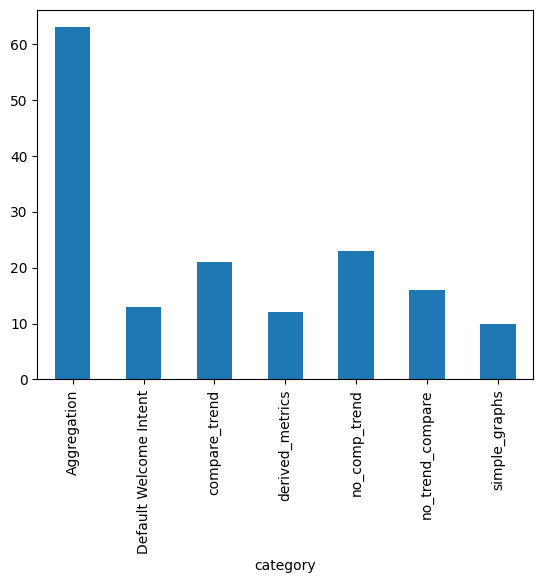

In [ ]:
df_train.groupby("category").size().plot.bar()

In [ ]:
# SMOTE

df_train0 = df_train.copy()
df_train['index'] = df_train.index
X_resampled, y_resampled = SMOTE().fit_resample(df_train[['index']], df_train['category'])
X_resampled['category'] = y_resampled

Data1 = X_resampled.merge(df_train[['index','text']], on='index', how='left').drop(['index'], axis=1)
Data2 = Data1[Data1['category'] == 'Default Welcome Intent'].drop_duplicates(subset=['category', 'text'], keep="first")
Data3 = pd.concat([Data1[Data1['category'] != 'Default Welcome Intent'], Data2], ignore_index=True).reset_index(drop=True)
df_train = Data3
df_train = df_train[~df_train['text'].isnull()]

<Axes: xlabel='category'>

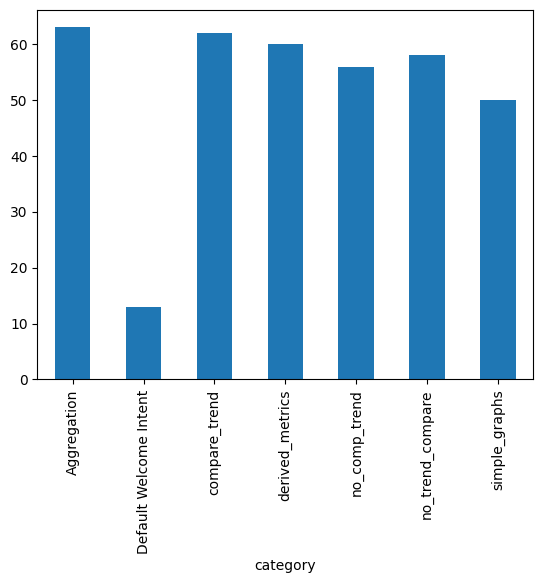

In [ ]:
df_train[~df_train['text'].isnull()].groupby("category").size().plot.bar()

## Model building

Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

For more information about how to build customized models in PyTorch, see [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop

Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a multi-class classification problem, I picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

>



In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
#    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 7
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=7, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 181/181 [00:19<00:00,  9.45it/s]


Epochs: 1 | Train Loss:  0.525             | Train Accuracy:  0.633             | Val Loss:  0.691             | Val Accuracy:  0.575


100%|██████████| 181/181 [00:16<00:00, 11.25it/s]


Epochs: 2 | Train Loss:  0.162             | Train Accuracy:  0.895             | Val Loss:  0.519             | Val Accuracy:  0.725


100%|██████████| 181/181 [00:15<00:00, 11.40it/s]


Epochs: 3 | Train Loss:  0.077             | Train Accuracy:  0.942             | Val Loss:  0.502             | Val Accuracy:  0.725


100%|██████████| 181/181 [00:16<00:00, 11.27it/s]


Epochs: 4 | Train Loss:  0.081             | Train Accuracy:  0.950             | Val Loss:  0.390             | Val Accuracy:  0.775


100%|██████████| 181/181 [00:16<00:00, 11.15it/s]


Epochs: 5 | Train Loss:  0.030             | Train Accuracy:  0.986             | Val Loss:  0.440             | Val Accuracy:  0.825


100%|██████████| 181/181 [00:16<00:00, 10.98it/s]


Epochs: 6 | Train Loss:  0.016             | Train Accuracy:  0.989             | Val Loss:  0.427             | Val Accuracy:  0.825


100%|██████████| 181/181 [00:16<00:00, 10.86it/s]


Epochs: 7 | Train Loss:  0.011             | Train Accuracy:  0.994             | Val Loss:  0.455             | Val Accuracy:  0.825


## Evaluation

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

In [ ]:
# train
# true_labels, pred_labels = evaluate(model, df_train)
labels_map = {0: 'Aggregation',
 1: 'compare_trend',
 2: 'Default Welcome Intent',
 3: 'derived_metrics',
 4: 'no_comp_trend',
 5: 'no_trend_compare',
 6: 'simple_graphs'}

In [ ]:
true_labels, pred_labels = evaluate(model, df_train0)

Accuracy:  0.994


In [ ]:
# dictionary of lists
dict = {'true_labels': true_labels, 'pred_labels': pred_labels}
df = pd.DataFrame(dict)
df.value_counts().unstack().replace(np.nan,'',regex=True)

pred_labels,0,1,2,3,4,5,6
true_labels,,,,,,,
0,63.0,,,,,,
1,,21.0,,,,,
2,,,13.0,,,,
3,,,,12.0,,,
4,,1.0,,,22.0,,
5,,,,,,16.0,
6,,,,,,,10.0


In [ ]:
# test
true_labels_test, pred_labels_test = evaluate(model, df_test)

Accuracy:  0.825


In [ ]:
dict = {'true_labels': true_labels_test, 'pred_labels': pred_labels_test}
df = pd.DataFrame(dict)
df.value_counts().unstack().replace(np.nan,'',regex=True)

pred_labels,0,1,2,3,4,5,6
true_labels,,,,,,,
0,16.0,,,,1.0,,
1,,1.0,,,,1.0,
2,,,3.0,,,,
3,1.0,,,1.0,1.0,,
4,,,,,7.0,,1.0
5,,1.0,,,,1.0,
6,,,,1.0,,,4.0


In [ ]:
print(classification_report(list(map(str, true_labels)), list(map(str, pred_labels))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       0.95      1.00      0.98        21
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        12
           4       1.00      0.96      0.98        23
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        10

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158



In [ ]:
print(classification_report(list(map(str, true_labels_test)), list(map(str, pred_labels_test))))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.50      0.50      0.50         2
           2       1.00      1.00      1.00         3
           3       0.50      0.33      0.40         3
           4       0.78      0.88      0.82         8
           5       0.50      0.50      0.50         2
           6       0.80      0.80      0.80         5

    accuracy                           0.82        40
   macro avg       0.72      0.71      0.71        40
weighted avg       0.82      0.82      0.82        40



## Saving the model

In [ ]:
with open("model/Intent_model.pkl", "wb") as f:
  pickle.dump(model.to('cpu'), f)

with open("model/Intent_tokenizer.pkl", "wb") as f:
  pickle.dump(tokenizer, f)

# **Fine-tuning BERT for named-entity recognition**

We are going to use **BertForTokenClassification** which is included in the [Transformers library](https://github.com/huggingface/transformers) by HuggingFace. This model has BERT as its base architecture, with a token classification head on top, allowing it to make predictions at the token level, rather than the sequence level. Named entity recognition is typically treated as a token classification problem, so that's what we are going to use it for.

In [ ]:
def convert_json(df):
  data = pd.DataFrame()
  for i in range(len(df)):
    query = []
    Tag = []
    Sentence = ['Sentence: {}'.format(i)]
    POS = [np.NaN for n in range(len(df.iloc[i]['data']))]
    for j in range(len(df.iloc[i]['data'])):
      query.append(df.iloc[i]['data'][j]['text'])
      try:
        Tag.append(df.iloc[i]['data'][j]['alias'])
      except:
        Tag.append('O')
      if j > 0:
        Sentence.append(np.NaN)

    dic = {'Sentence #':Sentence, 'Word':query, 'POS':POS, 'Tag':Tag}
    data = pd.concat([data, pd.DataFrame(dic)], ignore_index=True)
  return data

In [ ]:
df_concat = pd.DataFrame()
for df in [df1, df2, df3, df4, df5, df6, df7]:
  df_concat = pd.concat([df_concat, df], ignore_index=True)

Data = convert_json(df_concat)

In [ ]:
Data['Word'] = Data['Word'].str.strip()
Data['Tag'] = Data['Tag'].str.strip()

Data['Word'] = Data['Word'].replace('', np.nan)
Data.dropna(subset=['Word'], inplace = True)
Data=Data.reset_index(drop=True)

In [ ]:
# training for required tags only:
tags = ['DisplayColumns','AggColumns','date-period','DerivedMetricsColumns','FilterColumns']
Data.loc[~Data["Tag"].isin(tags), "Tag"] = 'O'

In [ ]:
# Unprocessed data
Data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 0,average,NaN,O
1,NaN,waste dollar,NaN,O
2,NaN,across,NaN,O
3,NaN,years,NaN,DisplayColumns
4,Sentence: 1,average,NaN,O


In [ ]:
df=Data

In [ ]:
def convert_string2(ip):
    ip_list = ip.split()
    rslt = []
    for w in ip_list:
      if ip_list.index(w)==0:
        rslt.append('B-'+ w)
      else:
        rslt.append('I-'+ w)
    return ' '.join(rslt)

In [ ]:
# CONDITION 1: BMI
filtered_values = np.where(df['Tag'] != 'O')
df1=df.loc[filtered_values]
df1['Word_'] = df1['Word'].map(convert_string2)

df2 = (df1
 .assign(Word_=df1['Word_'].str.split())
 .explode('Word_')
)
df2['Tag']=df2['Word_'].str[0:2] + df2['Tag']
df2['Word_']=df2['Word_'].str[2:]

df2['Word']=df2['Word_']
df2.drop(['Word_'], axis=1, inplace = True)

df2['index']=df2.index
df2['index_row'] = df2.sort_values(['index'], ascending=[True]).groupby(['index']).cumcount() + 1

df_cond1 = df2.copy()

In [ ]:
# CONDITION 2: Non BMI in case of 'O' tag
filtered_values = np.where(df['Tag'] == 'O')
df1=df.loc[filtered_values]

df2 = (df1
 .assign(Word=df1['Word'].str.split())
 .explode('Word')
)
df2['index']=df2.index
df2['index_row'] = df2.sort_values(['index'], ascending=[True]).groupby(['index']).cumcount() + 1

df_cond2 = df2.copy()

In [ ]:
pdList = [df_cond1, df_cond2]  # List of above dataframes
data = pd.concat(pdList).sort_values(['index','index_row'])
data.drop(['index','index_row'], axis=1, inplace=True)
data=data.reset_index(drop=True)

In [ ]:
# processed data for pipeline
data

,Sentence #,Word,POS,Tag
0,Sentence: 0,average,NaN,O
1,NaN,waste,NaN,O
2,NaN,dollar,NaN,O
3,NaN,across,NaN,O
4,NaN,years,NaN,B-DisplayColumns
...,...,...,...,...
1411,Sentence: 191,performance,NaN,O
1412,Sentence: 191,of,NaN,O
1413,NaN,beverages,NaN,B-FilterColumns
1414,NaN,in,NaN,O


Let's check how many sentences and words (and corresponding tags) there are in this dataset:

In [ ]:
len(data), data.count()

(1416,
 Sentence #     330
 Word          1416
 POS              0
 Tag           1416
 dtype: int64)



Let's have a look at the different NER tags, and their frequency:

In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 10


O                          997
B-FilterColumns            130
B-AggColumns                86
B-DisplayColumns            76
B-date-period               54
I-AggColumns                25
B-DerivedMetricsColumns     17
I-date-period               16
I-FilterColumns              9
I-DisplayColumns             6
Name: Tag, dtype: int64

We create 2 dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
labels_to_ids

{'O': 0,
 'B-DisplayColumns': 1,
 'B-AggColumns': 2,
 'I-DisplayColumns': 3,
 'B-FilterColumns': 4,
 'I-AggColumns': 5,
 'B-date-period': 6,
 'I-FilterColumns': 7,
 'I-date-period': 8,
 'B-DerivedMetricsColumns': 9}

As we can see, there are now only 10 different NER tags.

Now, we have to ask ourself the question: what is a training example in the case of NER, which is provided in a single forward pass? A training example is typically a **sentence**, with corresponding IOB tags. Let's group the words and corresponding tags by sentence:

In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 0,average,NaN,O
1,Sentence: 0,waste,NaN,O
2,Sentence: 0,dollar,NaN,O
3,Sentence: 0,across,NaN,O
4,Sentence: 0,years,NaN,B-DisplayColumns


In [ ]:
# let's create a new column called "sentence" which groups the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 0,average,NaN,O,average waste dollar across years,"O,O,O,O,B-DisplayColumns"
1,Sentence: 0,waste,NaN,O,average waste dollar across years,"O,O,O,O,B-DisplayColumns"
2,Sentence: 0,dollar,NaN,O,average waste dollar across years,"O,O,O,O,B-DisplayColumns"
3,Sentence: 0,across,NaN,O,average waste dollar across years,"O,O,O,O,B-DisplayColumns"
4,Sentence: 0,years,NaN,B-DisplayColumns,average waste dollar across years,"O,O,O,O,B-DisplayColumns"


In [ ]:
data.shape

(1416, 6)

Let's only keep the "sentence" and "word_labels" columns, and drop duplicates:

In [ ]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,average waste dollar across years,"O,O,O,O,B-DisplayColumns"
1,average sales across years,"O,O,O,B-DisplayColumns"
2,top contributing markets for sale across waste...,"O,O,B-AggColumns,O,O,O,B-DisplayColumns,I-Disp..."
3,top contributing categories for sale across ma...,"O,O,B-AggColumns,O,O,O,B-DisplayColumns,O"
4,what are top contributing categories for sale ...,"O,O,O,O,B-AggColumns,O,O,O,B-DisplayColumns,O"


Let's verify that a random sentence and its corresponding tags are correct:

#### **Preparing the dataset and dataloader**

Now that our data is preprocessed, we can turn it into PyTorch tensors such that we can provide it to the model. Let's start by defining some key variables that will be used later on in the training/evaluation process:

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 7
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

A tricky part of NER with BERT is that BERT relies on **wordpiece tokenization**, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then one approach could be to handle this by only train the model on the tag labels for the first word piece token of a word (i.e. only label "Wash" with "b-gpe"). This is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063).

Note that this is a **design decision**. You could also decide to propagate the original label of the word to all of its word pieces and let the model train on this. In that case, the model should be able to produce the correct labels for each individual wordpiece. This was done in [this NER tutorial with BERT](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L118). Another design decision could be to give the first wordpiece of each word the original word label, and then use the label “X” for all subsequent subwords of that word. All of them seem to lead to good performance.

Below, we define a regular PyTorch [dataset class](https://pytorch.org/docs/stable/data.html) (which transforms examples of a dataframe to PyTorch tensors). Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, the attention mask is created and the labels are created based on the dictionary which we defined above. Word pieces that should be ignored have a label of -100 (which is the default `ignore_index` of PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)).

For more information about BERT's inputs, see [here](https://huggingface.co/transformers/glossary.html).








In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index].strip().split()
        word_labels = self.data.word_labels[index].split(",")

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len

Now, based on the class we defined above, we can create 2 datasets, one for training and one for testing. Let's use a 80/20 split:

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
# oversampling DerivedMetricsColumns
train_dataset_samp = pd.concat([train_dataset, train_dataset[train_dataset['word_labels'].str.contains('DerivedMetricsColumns')]], ignore_index=True)

test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
training_set_samp = dataset(train_dataset_samp, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (190, 2)
TRAIN Dataset: (152, 2)
TEST Dataset: (38, 2)


In [ ]:
train_dataset.head()

,sentence,word_labels
0,compare and forecast waste % across markets fo...,"O,O,O,O,O,O,B-DisplayColumns,O,B-date-period"
1,best regions for beverages,"O,B-AggColumns,O,B-FilterColumns"
2,compare the sales of us this year vs last year...,"O,O,O,O,B-FilterColumns,B-date-period,I-date-p..."
3,what are top contributing markets for sale acr...,"O,O,O,O,B-AggColumns,O,O,O,B-DisplayColumns,O"
4,heya,O


Now, let's define the corresponding PyTorch dataloaders:

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader_samp = DataLoader(training_set_samp, **train_params)
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#### **Defining the model**

Here we define the model, BertForTokenClassification, and load it with the pretrained weights of "bert-base-uncased". The only thing we need to additionally specify is the number of labels (as this will determine the architecture of the classification head).

Note that only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset. This is also printed as a warning when you run the code cell below.

Then, we move the model to the GPU.

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

#### **Training the model**




In [ ]:
# training_set_samp for sampled
inputs = training_set_samp[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(2.3795, device='cuda:0', grad_fn=<NllLossBackward0>)

This looks good. Let's also verify that the logits of the neural network have a shape of (batch_size, sequence_length, num_labels):

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 10])

Next, we define the optimizer.

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Now let's define a regular PyTorch training function.

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    # training_loader_samp for sampled set
    for idx, batch in enumerate(training_loader_samp):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)[0],model(input_ids=ids, attention_mask=mask, labels=labels)[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

And let's train the model!

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.4978108406066895
Training loss epoch: 1.3836408301097591
Training accuracy epoch: 0.6254230288269008
Training epoch: 2
Training loss per 100 training steps: 0.745018482208252
Training loss epoch: 0.6549373269081116
Training accuracy epoch: 0.7954220369972017
Training epoch: 3
Training loss per 100 training steps: 0.31015703082084656
Training loss epoch: 0.372658536565013
Training accuracy epoch: 0.9248802350772057
Training epoch: 4
Training loss per 100 training steps: 0.243898406624794
Training loss epoch: 0.2415675608123221
Training accuracy epoch: 0.9476025586730119
Training epoch: 5
Training loss per 100 training steps: 0.1643930971622467
Training loss epoch: 0.1818883024701258
Training accuracy epoch: 0.9597734191663607
Training epoch: 6
Training loss per 100 training steps: 0.09573828428983688
Training loss epoch: 0.1267206914177755
Training accuracy epoch: 0.9705002425961095
Training epoch: 7
Training loss per 100 trainin

#### **Evaluating the model**

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)[0], model(input_ids=ids, attention_mask=mask, labels=labels)[1]

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Loss: {eval_loss}")
    print(f"Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
# labels, predictions = valid(model, training_loader)
print('training:')
true_labels, predictions = valid(model, training_loader)
print('testing:')
true_labels_test, predictions_test = valid(model, testing_loader)

training:
loss per 100 evaluation steps: 0.09101197868585587
Loss: 0.041573636086755676
Accuracy: 0.9917073088125719
testing:
loss per 100 evaluation steps: 0.06284826993942261
Loss: 0.08884305737324451
Accuracy: 0.979160390319362


In [ ]:
# dictionary of lists
dic = {'labels': true_labels, 'predictions': predictions, 'split': 'train'}
df = pd.DataFrame(dic)
dic_test = {'labels': true_labels_test, 'predictions': predictions_test, 'split': 'test'}
df_test = pd.DataFrame(dic_test)

Matrix = pd.concat([df, df_test], ignore_index=True)
# Matrix.to_csv('model/Matrix4.csv')

In [ ]:
Matrix[(Matrix['split']=='test') & (Matrix['labels']!='O')][['labels', 'predictions']].value_counts().unstack().replace(np.nan,'',regex=True)

predictions,B-AggColumns,B-DerivedMetricsColumns,B-DisplayColumns,B-FilterColumns,B-date-period,I-AggColumns,I-DisplayColumns,I-FilterColumns,I-date-period,O
labels,,,,,,,,,,
B-AggColumns,16.0,,,,,,,,,
B-DerivedMetricsColumns,,2.0,,2.0,,,,,,
B-DisplayColumns,,,15.0,,,,,,1.0,
B-FilterColumns,,,1.0,23.0,,,,,,
B-date-period,,,,,11.0,,,,,
I-AggColumns,,,,,,2.0,,,,
I-DisplayColumns,,,,,,,1.0,,,
I-FilterColumns,,,,,,,,1.0,,1.0
I-date-period,,,,,1.0,,,,1.0,


In [ ]:
Matrix[(Matrix['split']=='train') & (Matrix['labels']!='O')][['labels', 'predictions']].value_counts().unstack().replace(np.nan,'',regex=True)

predictions,B-AggColumns,B-DerivedMetricsColumns,B-DisplayColumns,B-FilterColumns,B-date-period,I-AggColumns,I-DisplayColumns,I-FilterColumns,I-date-period
labels,,,,,,,,,
B-AggColumns,67.0,,,,,,,1.0,
B-DerivedMetricsColumns,,13.0,,,,,,,
B-DisplayColumns,,,60.0,,,,,,
B-FilterColumns,,,1.0,104.0,,,,,
B-date-period,,,,,43.0,,,,
I-AggColumns,,,,,,23.0,,,
I-DisplayColumns,,,,,,,5.0,,
I-FilterColumns,,,1.0,2.0,,,,4.0,
I-date-period,,,,,4.0,,,,10.0


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(list(map(str, true_labels)), list(map(str, predictions))))
print(classification_report(list(map(str, true_labels_test)), list(map(str, predictions_test))))

                         precision    recall  f1-score   support

           B-AggColumns       0.99      0.99      0.99        68
B-DerivedMetricsColumns       1.00      1.00      1.00        13
       B-DisplayColumns       0.97      1.00      0.98        60
        B-FilterColumns       0.98      0.99      0.99       105
          B-date-period       0.91      1.00      0.96        43
           I-AggColumns       1.00      1.00      1.00        23
       I-DisplayColumns       1.00      1.00      1.00         5
        I-FilterColumns       0.80      0.57      0.67         7
          I-date-period       1.00      0.71      0.83        14
                      O       1.00      1.00      1.00       775

               accuracy                           0.99      1113
              macro avg       0.96      0.93      0.94      1113
           weighted avg       0.99      0.99      0.99      1113

                         precision    recall  f1-score   support

           B-AggColum

In [ ]:
from seqeval.metrics import classification_report
print(classification_report([true_labels], [predictions]))

                       precision    recall  f1-score   support

           AggColumns       0.99      0.99      0.99        68
DerivedMetricsColumns       1.00      1.00      1.00        13
       DisplayColumns       0.97      1.00      0.98        60
        FilterColumns       0.95      0.96      0.96       105
          date-period       0.85      0.93      0.89        43

            micro avg       0.95      0.97      0.96       289
            macro avg       0.95      0.98      0.96       289
         weighted avg       0.95      0.97      0.96       289



#### **Saving the model for future use**

In [ ]:
with open("model/Entity_model.pkl", "wb") as f:
  pickle.dump(model.to('cpu'), f)

with open("model/Entity_tokenizer.pkl", "wb") as f:
  pickle.dump(tokenizer, f)